In [24]:
ndvi_mask = 'ndvi-open-spaces.tif'
kmeans_mask = 'kmeans-open-spaces.tif'
segment_anything_mask = 'segment-anything.tif'

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import shapes
import pandas as pd
# from shapely.geometry import shape

In [ ]:
import rasterio
import numpy as np
from rasterio.plot import show
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import box, shape

# Open the GeoTIFF file
with rasterio.open(cropped_file) as src:

    print(src.read().shape)
    # Read the red and NIR bands (assuming band 4 is NIR)
    red = src.read(1).astype(float)
    nir = src.read(4).astype(float)

    # Calculate NDVI
    ndvi = (nir - red) / (nir + red)

    # Create a mask for non-vegetated areas (low NDVI values)
    open_space_mask = ndvi < 0.1  # Adjust the threshold based on the image characteristics


    mask = morphology.remove_small_holes(open_space_mask, area_threshold=10000)
    # show(open_space_mask, title='Open Spaces Mask')
    show(mask, title='Remove Small Holes Mask')

    mask = mask.astype('uint8')
    mask_transform = src.transform  # Affine transform for geographic coordinates
    geometries = list(shapes(mask, transform=mask_transform))

    # Create a list of shapes and their properties
    shapes_list = [{'properties': {'raster_val': v}, 'geometry': shape(geom)}
                for geom, v in geometries if v == 1]

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame.from_features(shapes_list)

    # Set the CRS (Coordinate Reference System) to match your raster data
    gdf.crs = src.crs

    # Save to Shapefile
    gdf.to_file("scratch/mask.shp")


In [ ]:
gdf['area_feet'] = gdf.area
gdf['area_acres'] = gdf['area_feet'] / 43560

In [42]:
def geotiff_to_gdf(filepath):
    with rasterio.open(filepath) as src:
        mask = src.read(1).astype('uint8')
        mask_transform = src.transform
        geometries = list(shapes(mask, transform=mask_transform))
        shapes_list = [{'properties': {'raster_val': v}, 'geometry': shape(geom)}
                        for geom, v in geometries if v == 0]
        gdf = gpd.GeoDataFrame.from_features(shapes_list)
        gdf.crs = src.crs
    return gdf

def gdf_to_shp(gdf, out_path):
    gdf.to_file(out_path)

def calculate_area(gdf):
    gdf['area_feet'] = gdf.area
    gdf['area_acres'] = gdf['area_feet'] / 43560
    return gdf['area_acres']

In [50]:
files = [ndvi_mask, kmeans_mask, segment_anything_mask]
results = []

for file in files:
    filename = file
    gdf = geotiff_to_gdf(file)    
    gdf['area_acres'] = calculate_area(gdf)
    results.append(gdf)

In [ ]:
bins = [0, 1/8, 1/4, 1/2, 1]  # The bins for the area sizes in acres
labels = ['1/8 acre', '1/4 acre', '1/2 acre', '1+ acres']

gdf_open_spaces['size_category'] = pd.cut(gdf_open_spaces['area_acres'], bins=bins, labels=labels, right=False)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(20, 20))  # Set the size of the figure
plot = gdf_open_spaces.plot(column='size_category', ax=ax, legend=True, categorical=True, legend_kwds={'title': 'Size Category'})
ax.set_title('Open Spaces Categorized by Size')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Improve the layout and display the plot
plt.tight_layout()
plt.show()

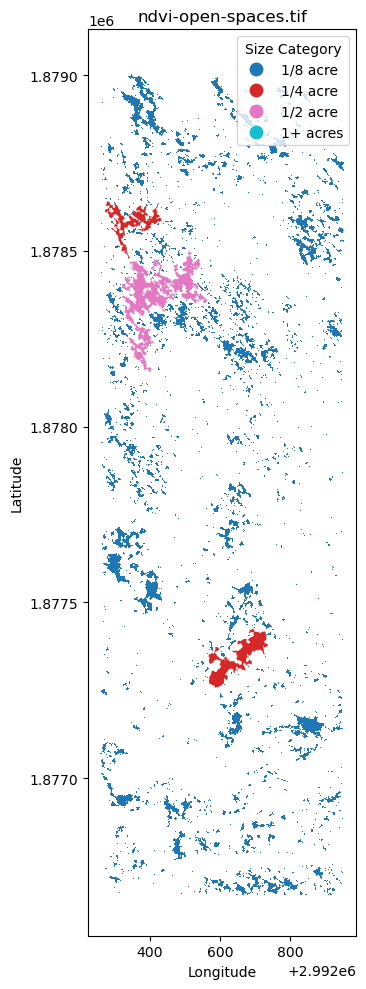

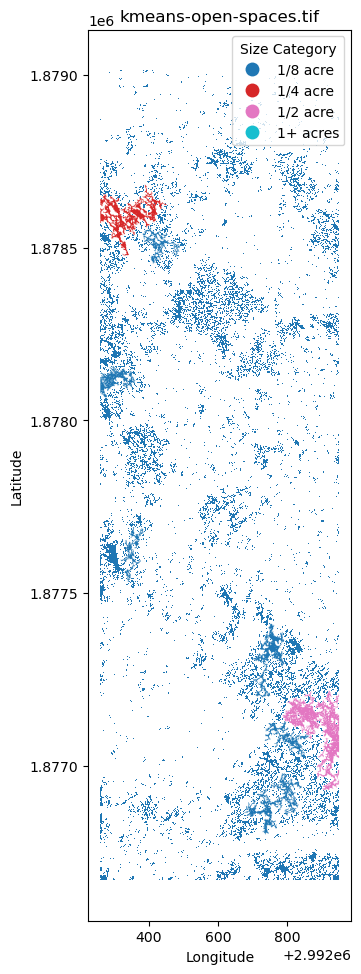

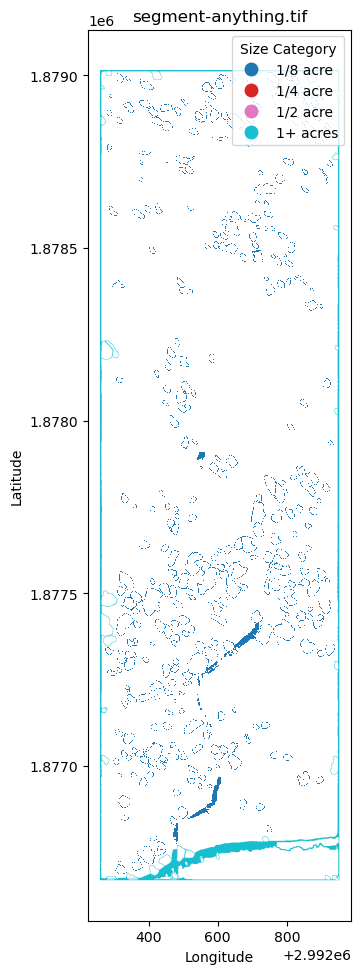

In [54]:
def bin_plot(gdf, bins, labels, title):
    gdf['size_category'] = pd.cut(gdf['area_acres'], bins=bins, labels=labels, right=False)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot = gdf.plot(column='size_category', ax=ax, legend=True, categorical=True, legend_kwds={'title': 'Size Category'})
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.tight_layout()
    filename = title.split('.')[0]
    plt.savefig(f'{filename}.png')
    plt.show()

for i, result in enumerate(results):
    bins = [0, 1/8, 1/4, 1/2, 1]
    labels = ['1/8 acre', '1/4 acre', '1/2 acre', '1+ acres']
    title = files[i]
    bin_plot(result, bins, labels, title)